In [2]:
import numpy as np
import skimage as sk
from skimage import morphology as skm
import cv2
import os
import matplotlib.pyplot as plt
import PIL

<a id='toc'></a>

# Summary

- [1. Load resources](#1)
- [2. Understanding the data](#2)
    - [2.1 Plot some images](#2.1)
    - [2.2 Images with csv points](#2.2)
- [3. Classification simple avec pre/post-traitements](#3)
    - [3.1 Séparation train/val/test](#3.1)
    - [3.2 Classification SVC](#3.2)
    - [3.3 Pre-traitement](#3.3)
    - [3.4 Post-traitement](#3.4)
- [4. Benchmark des méthodes de Classification](#4)
- [5. Méthode retenue](#5)
    - [5.1 Pipeline](#5.1)
    - [5.2 Résultats](#5.2)
    - [5.3 Identification des limites](#5.3)
- [Conclusion](#conclusion)

<a id='1'></a>
# 1. Load resources

In [3]:
#FIXME setup the folder location
TRAIN_FOLDER = "Data/TRAIN/"
EX_FOLDER = "Data/"

In [4]:
ex_imgs = [EX_FOLDER + path for path in os.listdir(EX_FOLDER) if path[:2] == "ex" and path[-3:] == "jpg"]
ex_imgs.sort()

In [5]:
ex_csv = [EX_FOLDER + path for path in os.listdir(EX_FOLDER) if path[:2] == "ex" and path[-3:] == "csv"]
ex_csv.sort()

In [6]:
train_imgs = [TRAIN_FOLDER + path for path in os.listdir(TRAIN_FOLDER) if path[-3:] == "jpg"]
train_imgs.sort()

<a id='2'></a>
# 2. Understanding the data

In [25]:
def plot_images(path_lst, csv=None, max=6):
    plt.figure(figsize=(20,15))
    for i, path in enumerate(path_lst):
        if i == max:
            break
        plt.subplot(max//2, 2, i+1)
        if csv:
            for point in np.genfromtxt(csv[i],delimiter=','):
                plt.plot(point[1], point[0], marker='x', color="red")
        im = cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2LAB)
        im,_,_ = cv2.split(im)
        #im = im - cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2GRAY)
        #im = cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2GRAY)
        plt.imshow(im, cmap="gray")
        
    plt.show()
        

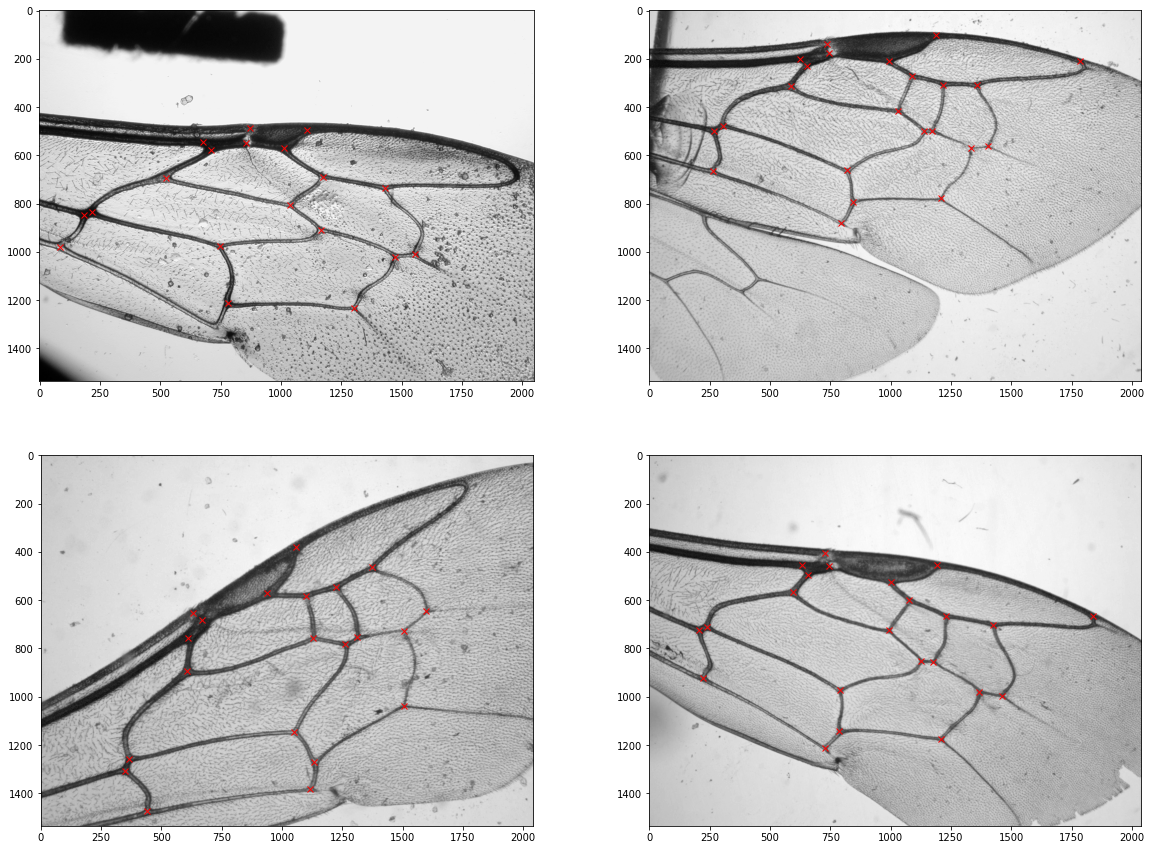

In [26]:
plot_images(ex_imgs,csv=ex_csv, max=4)

# 3 Blood vessel segmentation
## 3.1 Pre-processing

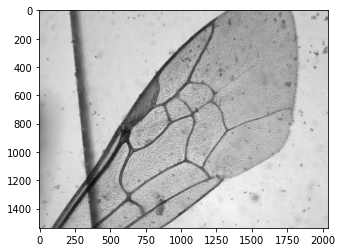

In [407]:
im = cv2.cvtColor(cv2.imread(train_imgs[16]), cv2.COLOR_BGR2LAB)
im,_,_ = cv2.split(im)
plt.imshow(im, cmap="gray")

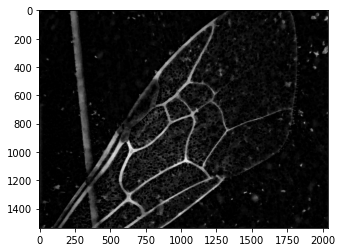

In [408]:
im_open = skm.opening(im, skm.disk(6))
im_hat = skm.black_tophat(im_open, skm.disk(30))
plt.imshow(im_hat, cmap="gray")

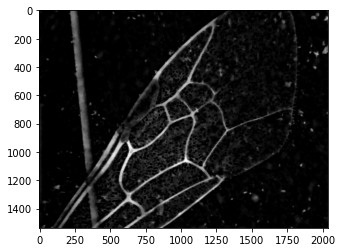

In [409]:
from scipy.ndimage import gaussian_filter
im_gaussian = gaussian_filter(im_hat, sigma=7/4)
plt.imshow(im_gaussian, cmap="gray")

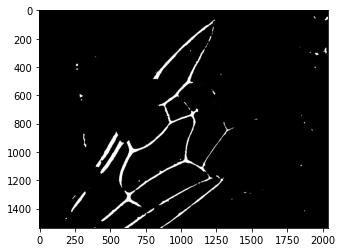

In [410]:
im_test = im_gaussian #skm.closing(im_gaussian, skm.disk(7))
plt.imshow(im_test>35, cmap="gray")

In [411]:
im_test_hat = skm.white_tophat(im_test > 35, skm.disk(5))

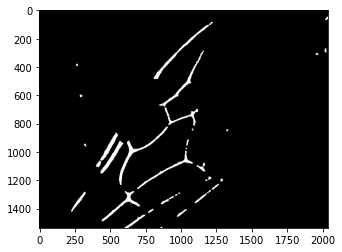

In [412]:
plt.imshow((im_test>35) ^ im_test_hat, cmap="gray")

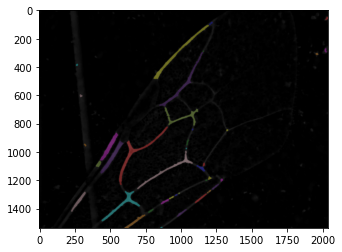

In [413]:
im_label = sk.measure.label((im_test>35) ^ im_test_hat)
im_label_overlay = sk.color.label2rgb(im_label, image=im_test, bg_label=0)
plt.imshow(im_label_overlay)

In [414]:
tmp = np.where(np.bincount(im_label.flatten()) > 7000)[0][1:]
im_filter = []
for value in im_label.flatten():
    im_filter.append(value in tmp)
im_filter = np.array(im_filter).reshape(im_label.shape)

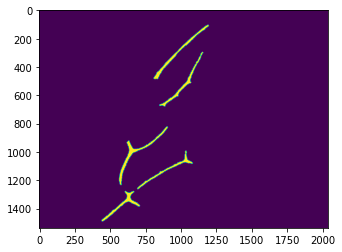

In [415]:
plt.imshow(im_filter)

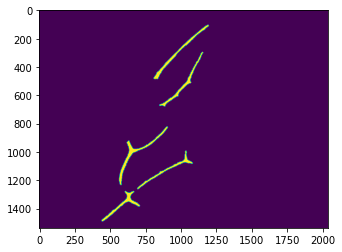

In [416]:
res = skm.binary_closing(im_filter, skm.disk(12))
plt.imshow(res)

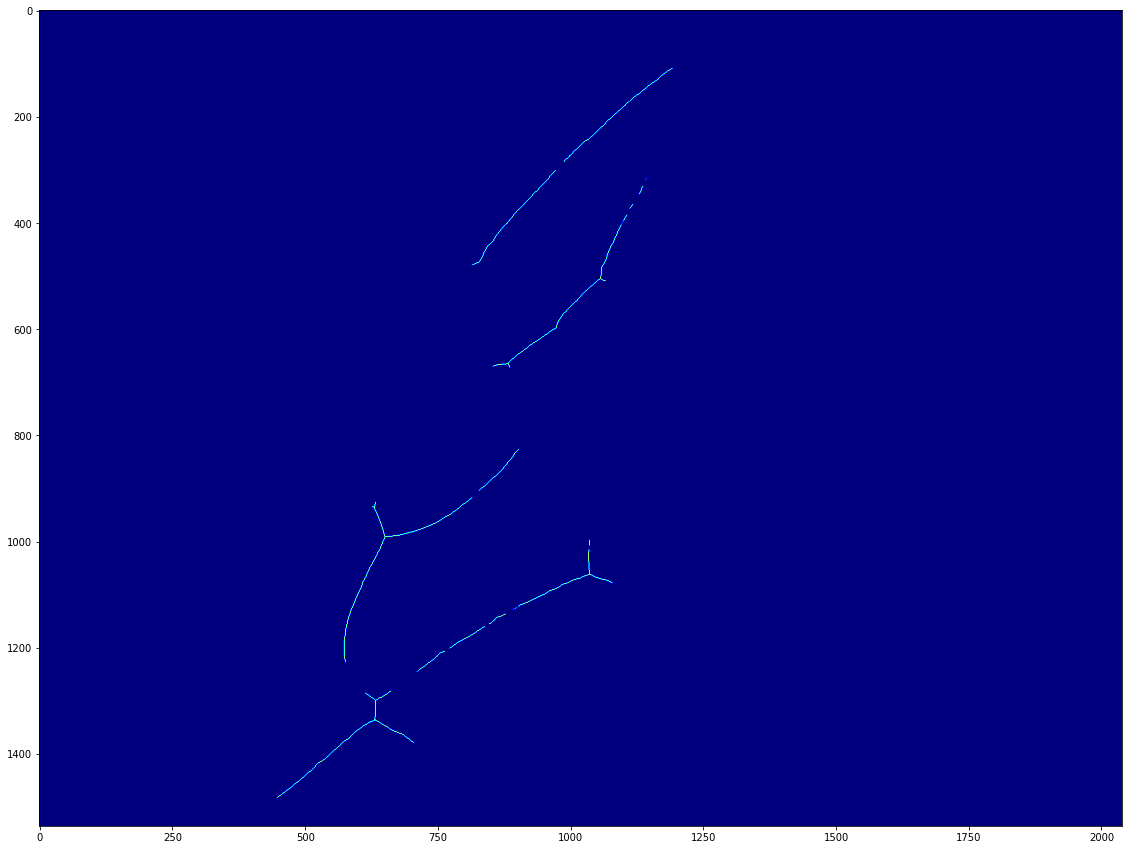

In [417]:
plt.figure(figsize=(20,15))
plt.imshow(skm.skeletonize(gaussian_filter(res, sigma=0.9)), cmap="jet")

In [418]:
im_sk = skm.skeletonize(gaussian_filter(res, sigma=0.9))

In [419]:
im_sk.shape

(1536, 2039)

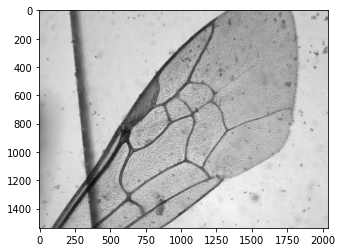

In [420]:
plt.imshow(im, cmap="gray")

In [421]:
def my_subtract(a,b):
    res = np.copy(a)
    if a.shape[0] % 2 == 0 or a.shape[1] != a.shape[0] or b.shape[0] % 2 == 0 or b.shape[1] != b.shape[0]:
        return
    dif = abs(a.shape[0] // 2 - b.shape[0] // 2)
    for i in range(b.shape[0]):
        for j in range(b.shape[0]):
            res[dif+i,dif+j] -= b[i,j]
    return res    

In [422]:
ring = my_subtract(skm.square(7), skm.square(5))
ring

array([[1, 1, 1, 1, 1, 1, 1],
       [1, 0, 0, 0, 0, 0, 1],
       [1, 0, 0, 0, 0, 0, 1],
       [1, 0, 0, 0, 0, 0, 1],
       [1, 0, 0, 0, 0, 0, 1],
       [1, 0, 0, 0, 0, 0, 1],
       [1, 1, 1, 1, 1, 1, 1]], dtype=uint8)

In [423]:
pading = len(ring)
points = np.zeros_like(im)
for i in range(im_sk.shape[1] - pading):
    for j in range(im_sk.shape[0] - pading):
        sum = len(np.bincount(sk.measure.label(im_sk[j:j + pading, i:i + pading] * ring).flatten()))
        if sum > 3 :
            points[j + pading // 2, i + pading // 2] = 1
            
        

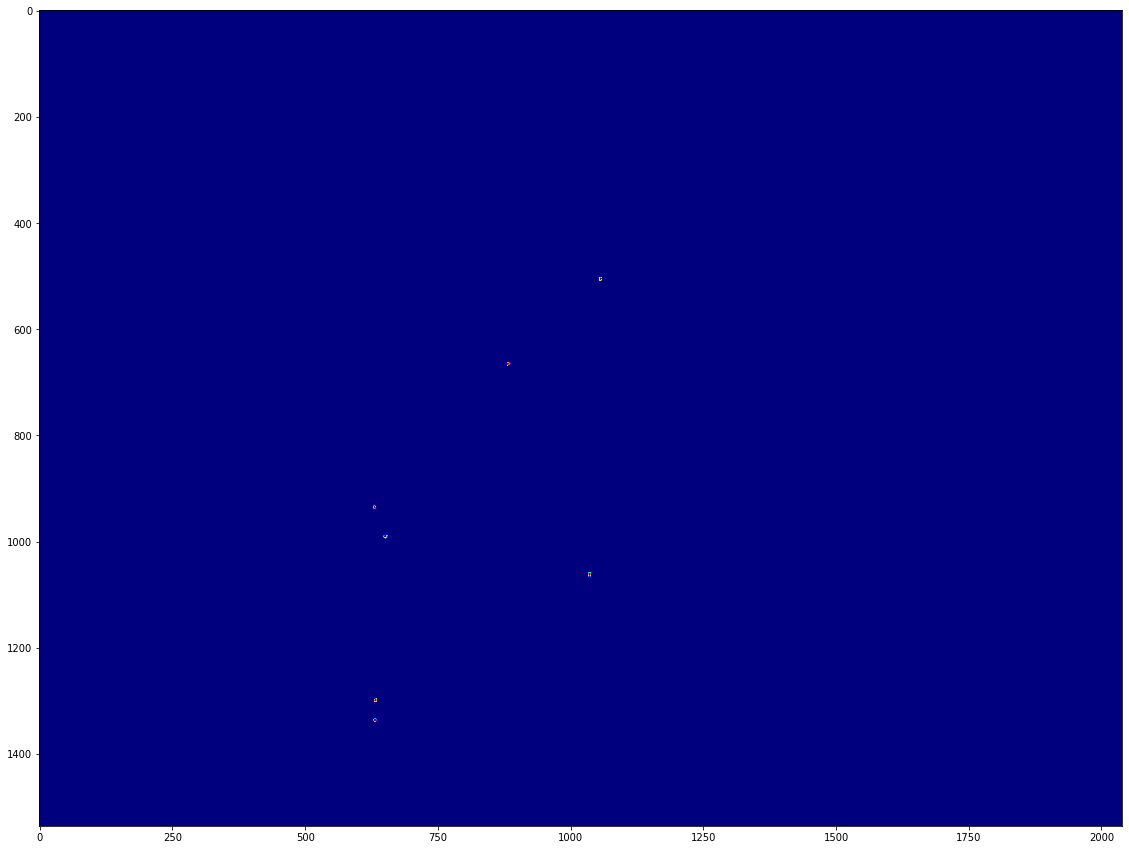

In [424]:
plt.figure(figsize=(20,15))
plt.imshow((points), cmap="jet")

In [425]:
def imageDotsToCentroidList(img):
    im = skm.dilation(img, skm.disk(8))
    nb_components, output, stats, centroids = cv2.connectedComponentsWithStats(im)
    return centroids

In [426]:
imageDotsToCentroidList(points).shape

(8, 2)

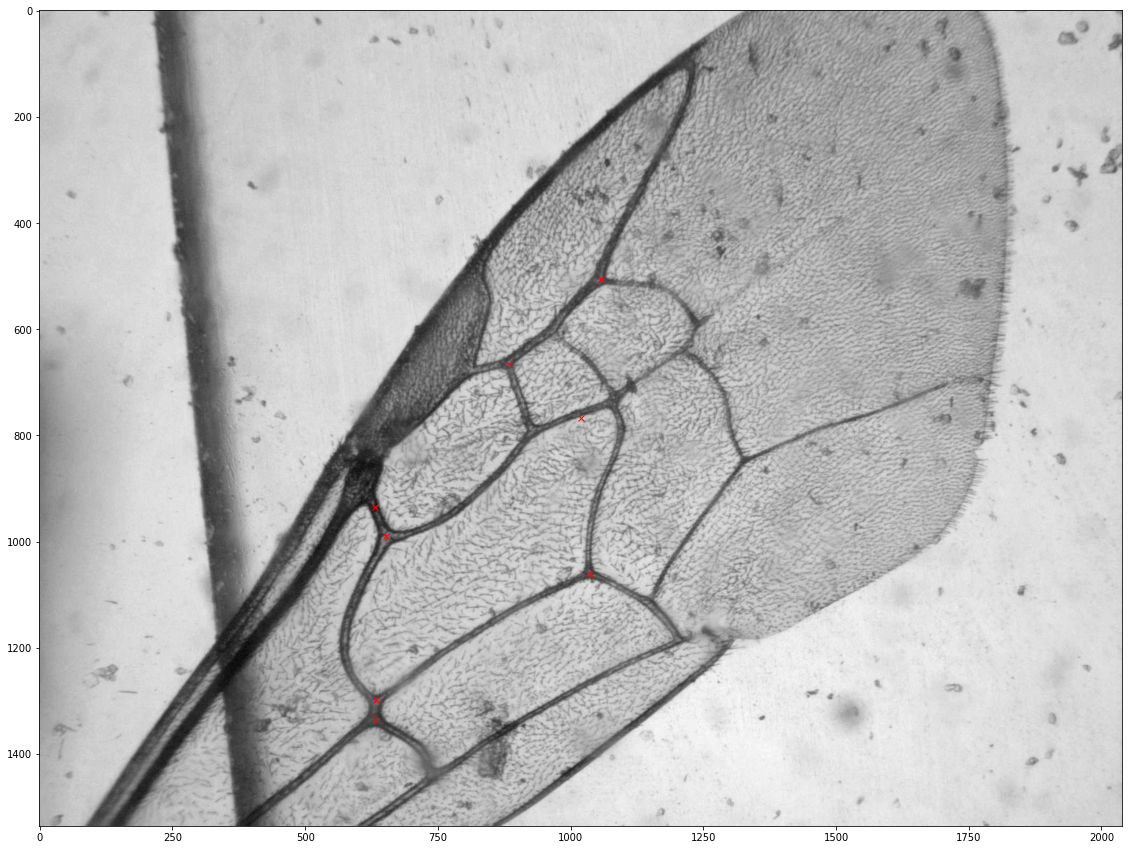

In [427]:
plt.figure(figsize=(20,15))
for point in imageDotsToCentroidList(points):
        plt.plot(point[0], point[1], marker='x', color="red")
plt.imshow(im, cmap="gray")